In [1]:
import pandas as pd
import sqlalchemy
import numpy as np
import os, sys, copy, random, pickle, cv2, math
from matplotlib import pyplot as plt
%matplotlib inline
# sys.path.append("../")
# %load_ext autoreload
# %autoreload 2
from IPython.display import display
import json

In [2]:
os.getcwd()

'C:\\Users\\wsutt\\Desktop\\alphaPilot\\books'

##### random_submission.json - based off leader img-set

In [3]:
p_json = '../starter_scripts_v2/starter_scripts_v2/random_submission.json'
submission = json.load(open(p_json, 'r'))

In [4]:
print type(submission)
keys = submission.keys()
len(keys)

<type 'dict'>


1161

##### summarize img directories: leader and training

In [5]:
# p_leader = '../Data_LeaderboardTesting/Data_LeaderboardTesting/'
p_leader = '../testing/images/'
dir_leader = os.listdir(p_leader)
print len(dir_leader)
dir_leader[:5]

1161


['IMG_0008.JPG',
 'IMG_0023.JPG',
 'IMG_0030.JPG',
 'IMG_0038.JPG',
 'IMG_0070.JPG']

In [6]:
p_training = '../Data_Training/Data_Training/'
dir_training = os.listdir(p_training)
print len(dir_training)
dir_training[:5]

9339


['IMG_0005.JPG',
 'IMG_0006.JPG',
 'IMG_0007.JPG',
 'IMG_0012.JPG',
 'IMG_0013.JPG']

##### show how random_submission.json aligns with leader img-set, not training img-set

In [7]:
sub0 = str(submission.keys()[0])
print sub0

print sub0 in dir_training
print sub0 in dir_leader

print "IMG_5677.JPG" in dir_training
print "IMG_5677.JPG" in dir_leader

IMG_8128 (1).JPG
False
True
True
False


##### load ground truth

In [8]:
p_truth = '../training_GT_labels_v2.json'
truth = json.load(open(p_truth, 'r'))

In [9]:
print type(truth)
print len(truth.keys())
truth.items()[:3]

<type 'dict'>
9339


[(u'IMG_0461.JPG', [[589, 352, 739, 361, 734, 527, 587, 532]]),
 (u'IMG_9622.JPG', [[582, 438, 768, 428, 774, 620, 577, 625]]),
 (u'IMG_9925.JPG', [[466, 285, 762, 254, 777, 603, 475, 592]])]

##### describe workflow

we'll be generating a json in the same format as random_submission.json to upload to the website

this will be based on the output of the algo from leader-img-set (1161 images)

the scoring_scripts can't actually be run on the output of generate_submission.py as we have no ground-truth file for this set of images.

but we can run scoring scripts on training images (9339 of em) and an associated random/naive predictor. To do this:
 1. > python starter_scripts_v2/starter_scripts_v2/generate_submissions2.py [this should generate random_submission3.json]
 2. > python scorer_scripts_v2/scorer_scripts_v2/score_detections.py -g training_GT_labels_v2.json -p random_submission3.json
     
    output: 9339
    9339
    COCO mAP for detector is 3.69628231815e-05

##### plot examples

In [10]:
def drawRect(img, rect, color='yellow', thick=3):
    COLOR = (0, 255, 255)
    if color == 'blue':
        COLOR = (255,0,0)
    return cv2.rectangle(img, rect[0], rect[1], COLOR, thick)
def drawPoly(img, poly, color='yellow', thick=3):
    COLOR = (0, 255, 255)
    if color == 'blue':
        COLOR = (255,0,0)
    return cv2.polylines(img, [poly], True, COLOR, thick)
def answerToRect(answer):
    a = answer[0]
    x = [v for i,v in enumerate(a) if i % 2 == 0]
    y = [v for i,v in enumerate(a) if i % 2 == 1]
    return ((min(x), min(y)), (max(x), max(y)))  
def answerToPoints(answer):
    a = answer[0]
    x = [v for i,v in enumerate(a) if i % 2 == 0]
    y = [v for i,v in enumerate(a) if i % 2 == 1]
    return np.array( [[e[0], e[1]] for e in zip(x,y)] )

In [11]:
p_training = '../Data_Training/Data_Training/'
def loadImg(fn):
    return cv2.imread(p_training + fn)
def plotImg(img, rect=None, poly=None):
    if rect is not None:
        img = drawRect(img.copy(), rect, thick=10)
    if poly is not None:
        img = drawPoly(img.copy(), poly, thick=10)
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    plt.imshow(img)

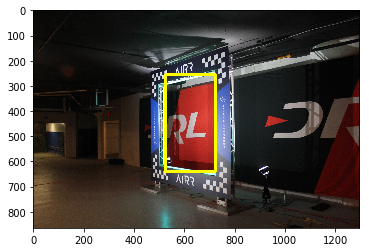

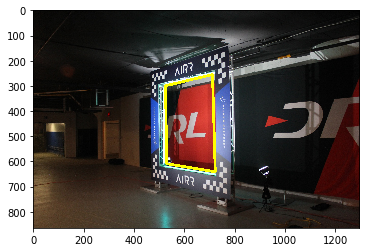

In [12]:
# where rect != polygon
fn = 'IMG_1125.JPG'
example_img = loadImg(fn)

answer = truth[fn]
rect = answerToRect(answer)
plotImg(example_img, rect=rect)
plt.show()

tmp_example = example_img.copy()
poly = answerToPoints(answer)
plotImg(tmp_example, poly=poly)

IMG_0029.JPG
[[440 165]
 [879 169]
 [884 584]
 [437 590]]


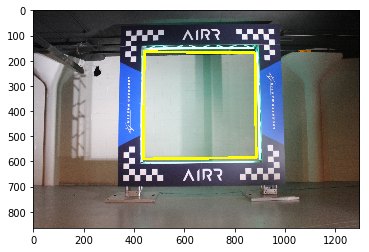

In [13]:
def myPlot(ind, poly=None, polys=None):

    fn = dir_training[ind]
    img = loadImg(fn)
    answer = truth[fn]
    rect = answerToRect(answer)
    if poly is None:
        poly = answerToPoints(answer)
    if polys is not None:
        
    
    plotImg(img, poly=poly)

    print fn
    print poly
    
i = 10
myPlot(i)

IMG_8141 (1).JPG
[[694 516]
 [756 499]
 [756 663]
 [698 663]]


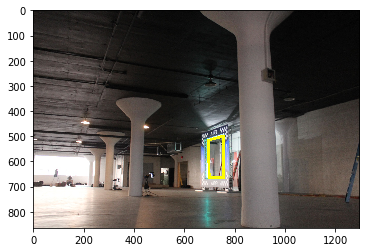

IMG_5177.JPG
[[426 407]
 [601 395]
 [604 575]
 [433 575]]


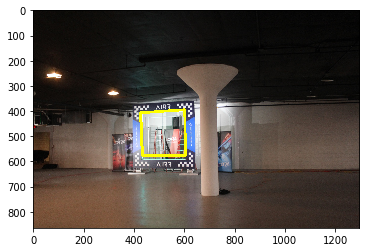

IMG_5768.JPG
[[527 354]
 [703 349]
 [698 525]
 [530 525]]


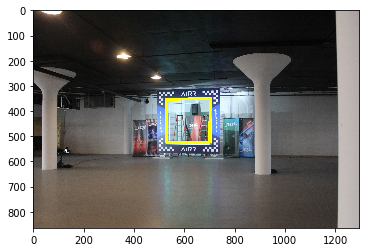

IMG_7494 (1).JPG
[[618 416]
 [701 392]
 [699 615]
 [616 615]]


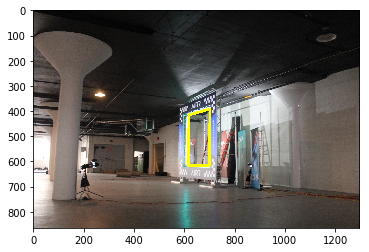

IMG_1378.JPG
[[551 404]
 [660 392]
 [660 570]
 [552 563]]


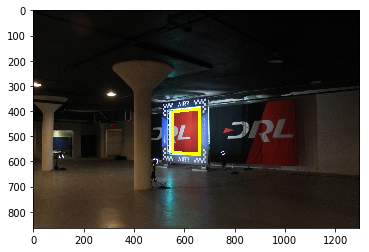

In [14]:
N=5
for i in random.sample(range(len(dir_training)), N):
    myPlot(i)
    plt.show()

##### build an average guess submission for training set

In [15]:
all_points = []
for _item in truth.items():
    _answer = _item[1]
    np_points = answerToPoints(_answer)
    points = np_points.tolist()
    all_points.append(points)

print len(all_points)
all_points[:4]    

9339


[[[589, 352], [739, 361], [734, 527], [587, 532]],
 [[582, 438], [768, 428], [774, 620], [577, 625]],
 [[466, 285], [762, 254], [777, 603], [475, 592]],
 [[485, 324], [787, 260], [813, 637], [485, 654]]]

In [16]:
has_points = filter(lambda point: point != [], all_points)
print len(all_points), len(has_points)

9339 9334


In [17]:
means = [np.mean([_point[p][x] for _point in has_points]) for p in range(4) for x in range(2)]
means   

[529.1341332761946,
 335.0982429826441,
 727.459074351832,
 334.7421255624598,
 728.5013927576601,
 597.3908292264838,
 527.4163274051854,
 598.7229483608314]

##### build means2, the outer box

In [62]:
mean_points = np_prediction.tolist()
mean_points

[[529, 335], [727, 334], [728, 597], [527, 598]]

In [63]:
width = mean_points[1][0] - mean_points[0][0] 
width

198

In [64]:
height = mean_points[2][1] - mean_points[0][1]
height

262

In [66]:
FACTOR = 3.0/8.0
FACTOR

0.375

In [67]:
delta_w = float(width*FACTOR)/2.0
delta_w

37.125

In [68]:
delta_h = float(height*FACTOR)/2.0
delta_h

49.125

In [77]:
mp = mean_points

mp2 = [
             [mp[0][0] - delta_w, mp[0][1] - delta_h]
            ,[mp[1][0] + delta_w, mp[1][1] - delta_h]
            ,[mp[2][0] + delta_w, mp[2][1] + delta_h]
            ,[mp[3][0] - delta_w, mp[3][1] + delta_h]
]
print mp
print mp2

[[529, 335], [727, 334], [728, 597], [527, 598]]
[[491.875, 285.875], [764.125, 284.875], [765.125, 646.125], [489.875, 647.125]]


In [ ]:
print p

In [81]:
import itertools

In [83]:
means2 = [item for sublist in mp2 for item in sublist]
means2

[491.875, 285.875, 764.125, 284.875, 765.125, 646.125, 489.875, 647.125]

In [100]:
means

[529.1341332761946,
 335.0982429826441,
 727.459074351832,
 334.7421255624598,
 728.5013927576601,
 597.3908292264838,
 527.4163274051854,
 598.7229483608314]

In [101]:
means2

[491.875, 285.875, 764.125, 284.875, 765.125, 646.125, 489.875, 647.125]

##### avg for 2 boxes against random images

In [98]:
mp

[[529, 335], [727, 334], [728, 597], [527, 598]]

In [99]:
np_prediction = answerToPoints([[int(x) for x in means]])
np_prediction

array([[529, 335],
       [727, 334],
       [728, 597],
       [527, 598]])

IMG_2764.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]
 [491 285]
 [764 284]
 [765 646]
 [489 647]]


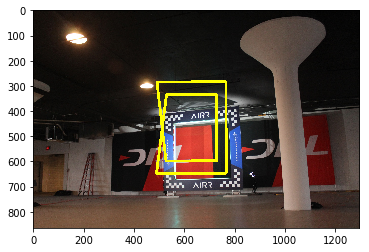

IMG_7874 (1).JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]
 [491 285]
 [764 284]
 [765 646]
 [489 647]]


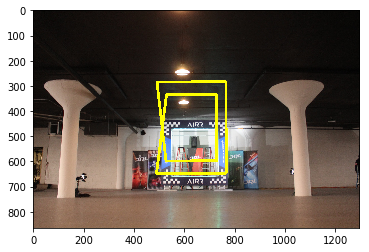

IMG_4729.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]
 [491 285]
 [764 284]
 [765 646]
 [489 647]]


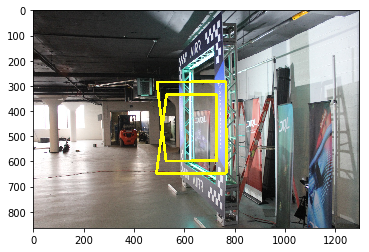

IMG_9329.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]
 [491 285]
 [764 284]
 [765 646]
 [489 647]]


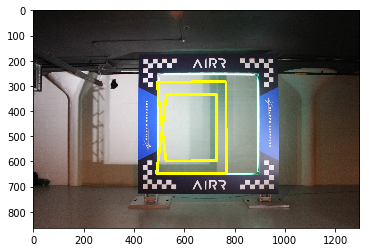

IMG_2746.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]
 [491 285]
 [764 284]
 [765 646]
 [489 647]]


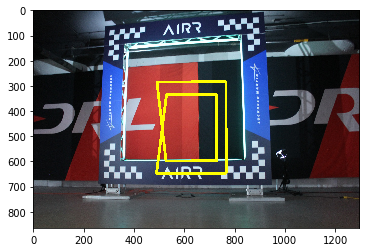

In [92]:
N=5
for i in random.sample(range(len(dir_training)), N):
    two_poly = copy.copy(mp)
    two_poly.extend(copy.copy(mp2))
#     two_poly = copy.copy(mp2)
    two_poly = [[int(e[0]), int(e[1])] for e in two_poly]
    two_poly=np.array(two_poly)
    
    myPlot(i, poly = two_poly)
    plt.show()

##### Does the mean rect look reasonable aginst training images?

IMG_8068.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]]


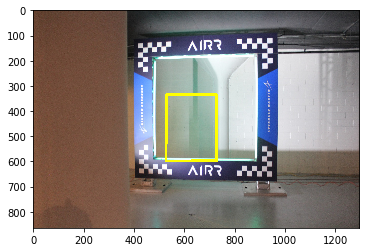

IMG_3140.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]]


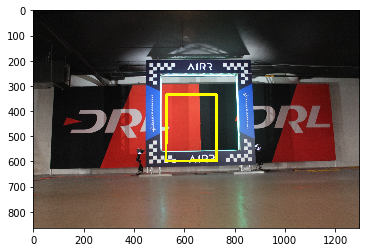

IMG_4041.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]]


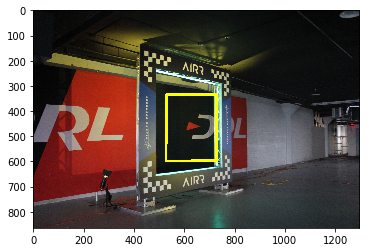

IMG_6974 (1).JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]]


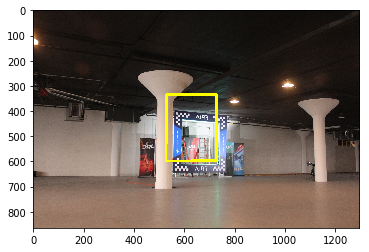

IMG_5424.JPG
[[529 335]
 [727 334]
 [728 597]
 [527 598]]


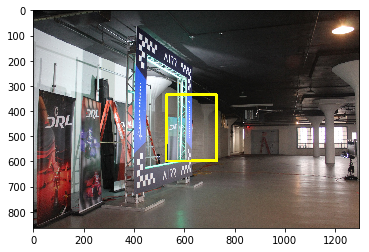

In [19]:
N=5
for i in random.sample(range(len(dir_training)), N):
    myPlot(i, poly = np_prediction)
    plt.show()

##### score for inside box

In [35]:
mean_prediction = {}
for fn in dir_training:
    mean_prediction[str(fn)] = [copy.copy(means)]
len(mean_prediction.keys())

9339

In [36]:
with open('mean_submission.json', 'w') as f:
    json.dump(mean_prediction, f)

In [37]:
sys.path.append('../')

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
with open('mean_submission.json', 'r') as f:
    myjson = json.load(f)

In [41]:
from scorer_scripts_v2.scorer_scripts_v2.score_detections import score

In [42]:
p_truth = '../training_GT_labels_v2.json'
p_mean_pred = 'mean_submission.json'
score(p_truth, p_mean_pred)

9339 9339
COCO mAP for detector is 0.242811220113


0.24281122011321563

##### try score for two boxes

In [93]:
mean_prediction2 = {}
for fn in dir_training:
    mean_prediction2[str(fn)] = [copy.copy(means), copy.copy(means2)]
len(mean_prediction2.keys())

9339

In [95]:
with open('mean_submission_2box.json', 'w') as f:
    json.dump(mean_prediction2, f)

In [96]:
with open('mean_submission_2box.json', 'r') as f:
    myjson2 = json.load(f)

In [97]:
p_truth = '../training_GT_labels_v2.json'
p_mean_pred = 'mean_submission_2box.json'
score(p_truth, p_mean_pred)

9339 9339
COCO mAP for detector is 0.158502204489


0.15850220448948377

is this good? is it 0-1?

try doing it for a mini training img set, and then try doing it where pred=truth

##### pred=actual

In [56]:
# the problem is truth_pred doesn't work in score()
truth_pred = {}
truth_pred2 = {}
truth_pred3 = {}

for _k in truth.keys():
    
    truth_pred[_k] = truth[_k]
    
    if truth[_k] == [[]]:
        truth_pred2[_k] = [means]
        truth_pred3[_k] = [means]
        
    else:
        truth_pred2[_k] = truth[_k]
        truth_pred3[_k] = truth[_k]
    
    

print len(truth_pred.keys())

with open('truth_submission.json', 'w') as f:
    json.dump(truth_pred, f)
    
with open('truth_submission2.json', 'w') as f:
    json.dump(truth_pred2, f)
    
with open('truth_submission3.json', 'w') as f:
    json.dump(truth_pred3, f)

9339


In [55]:
p_truth = '../training_GT_labels_v2.json'
p_truth_pred = 'truth_submission.json'
p_truth_pred2 = 'truth_submission2.json'

score(p_truth, p_truth_pred2)

9339 9339
COCO mAP for detector is 0.908896222099


0.9088962220989207

In [57]:
p_truth = '../training_GT_labels_v2.json'
p_truth_pred3 = 'truth_submission3.json'

score(p_truth, p_truth_pred3)

9339 9339
COCO mAP for detector is 0.908896222099


0.9088962220989207

In [48]:
p_truth = '../training_GT_labels_v2.json'
p_truth_pred = 'truth_submission.json'
score(p_truth, p_truth_pred)

9339 9339


IndexError: index -1 is out of bounds for axis 1 with size 0